# Regression analysis

This notebook demnstrates the regression analysis on
* credibleSetSize
* MAF
* beta

The analysis is performed using random effect model and fixed effect model.

Since this is a meta analysis betwen the different datasets, we need to be sure that we do not invalidate the independence assumption of the regression model, hence we use the `studyType` as a random effect covariate.

## Data Loading

The goal of this notebook is to check the distribution of study types in the dataset. 

In [ ]:
from gentropy.common.session import Session
from plotnine import (
    aes,
    after_stat,
    element_blank,
    element_line,
    element_rect,
    element_text,
    facet_grid,
    geom_density,
    geom_histogram,
    ggplot,
    labs,
    scale_x_continuous,
    theme,
)
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


25/06/22 21:10:07 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/06/22 21:10:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/22 21:10:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/22 21:10:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/22 21:10:08 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
session.spark


In [9]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)
dataset = dataset_maf.df.select(
    "rescaledStatistics.estimatedBeta",
    "studyStatistics.studyType",
    f.col("majorLdPopulationMaf").getField("value").alias("MAF"),
    "credibleSetSize",
)


## Plot the distributions of all variables across study types

In [ ]:
data = dataset.toPandas()
data


,estimatedBeta,studyType,MAF,credibleSetSize
0,0.448513,eqtl,0.391974,63
1,0.944703,eqtl,0.092805,25
2,-0.488767,tuqtl,0.187984,128
3,3.130259,tuqtl,0.028168,2
4,-1.213414,gwas,0.031283,7
...,...,...,...,...
2833753,-0.788485,eqtl,0.308891,1
2833754,NaN,gwas,0.000000,1
2833755,0.372572,eqtl,0.344172,13
2833756,-0.488811,gwas,0.022375,4


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 2744 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 2744 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 14 rows containing missing values.


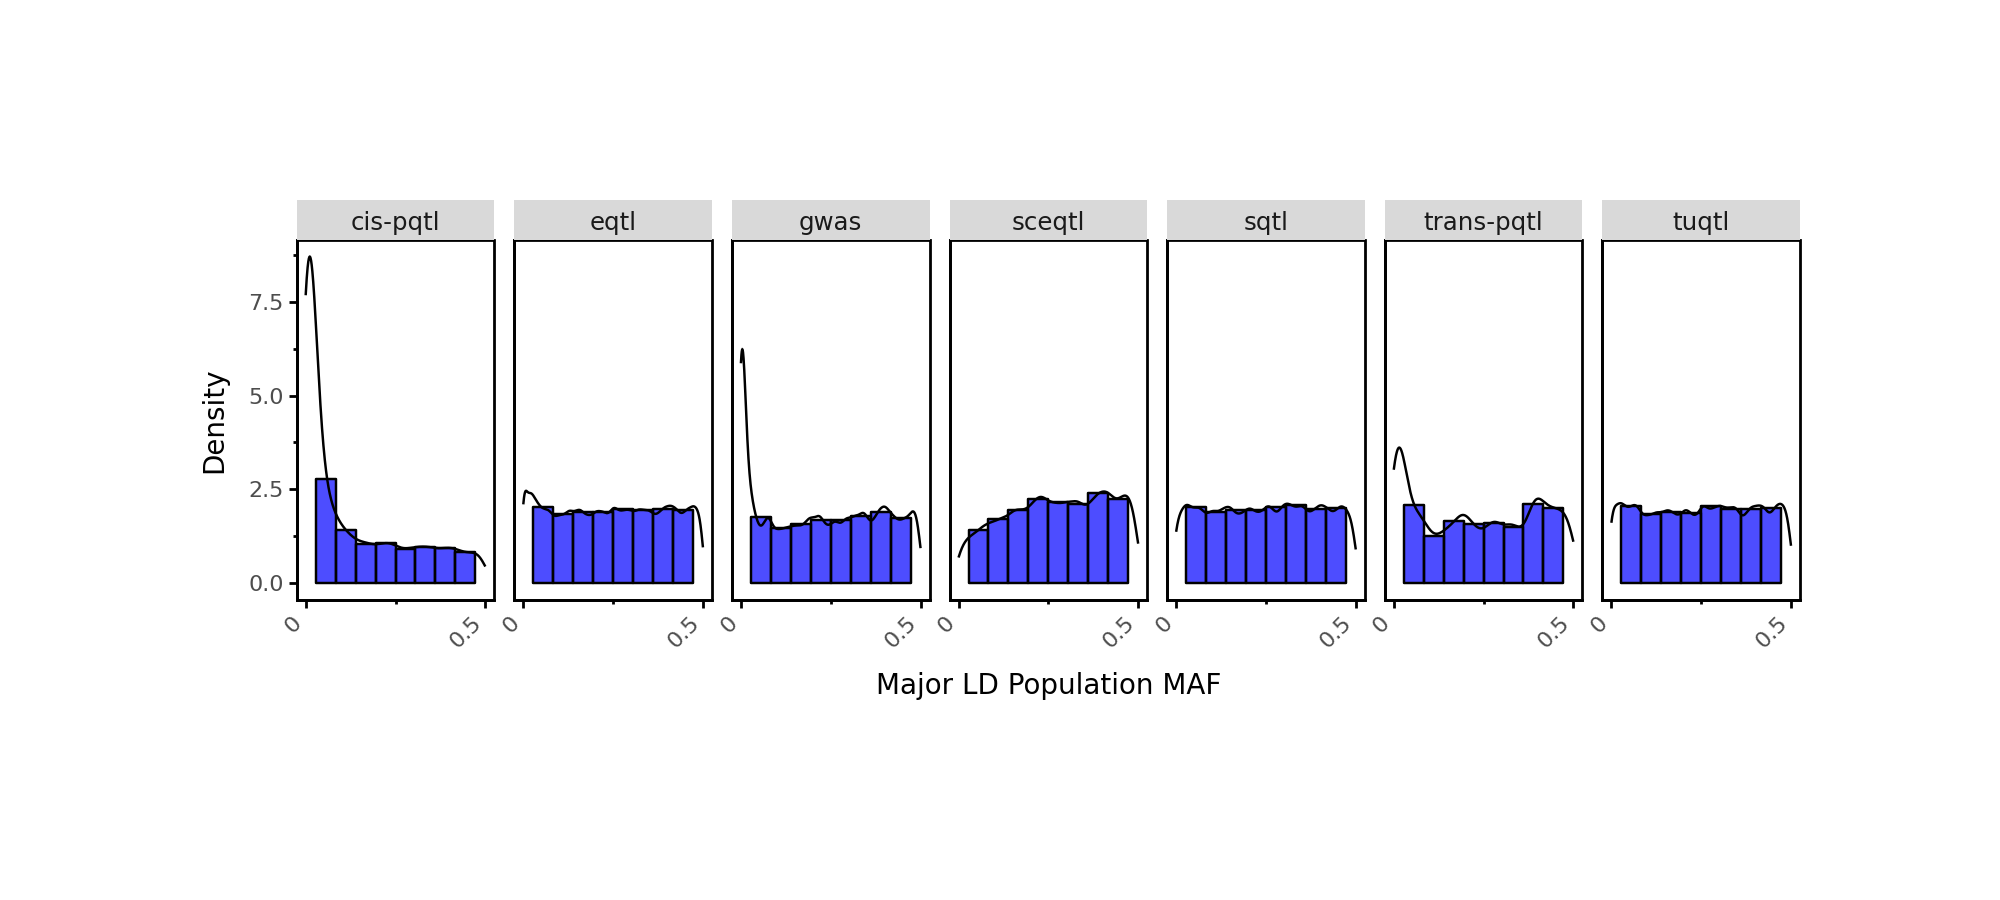

In [50]:
REM = 10

plot = (
    ggplot(data, aes(x="MAF", y=after_stat("count")))
    + geom_histogram(bins=10, fill="blue", color="black", alpha=0.7)
    + facet_grid(cols="studyType")
    + theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        plot_margin=0.1,
    )
    + labs(x="Major LD Population MAF", y="Count")
    + geom_density()
    + scale_x_continuous(
        limits=(0, 0.5),
        breaks=[0, 0.5],
        labels=["0", "0.5"],
    )
)
plot


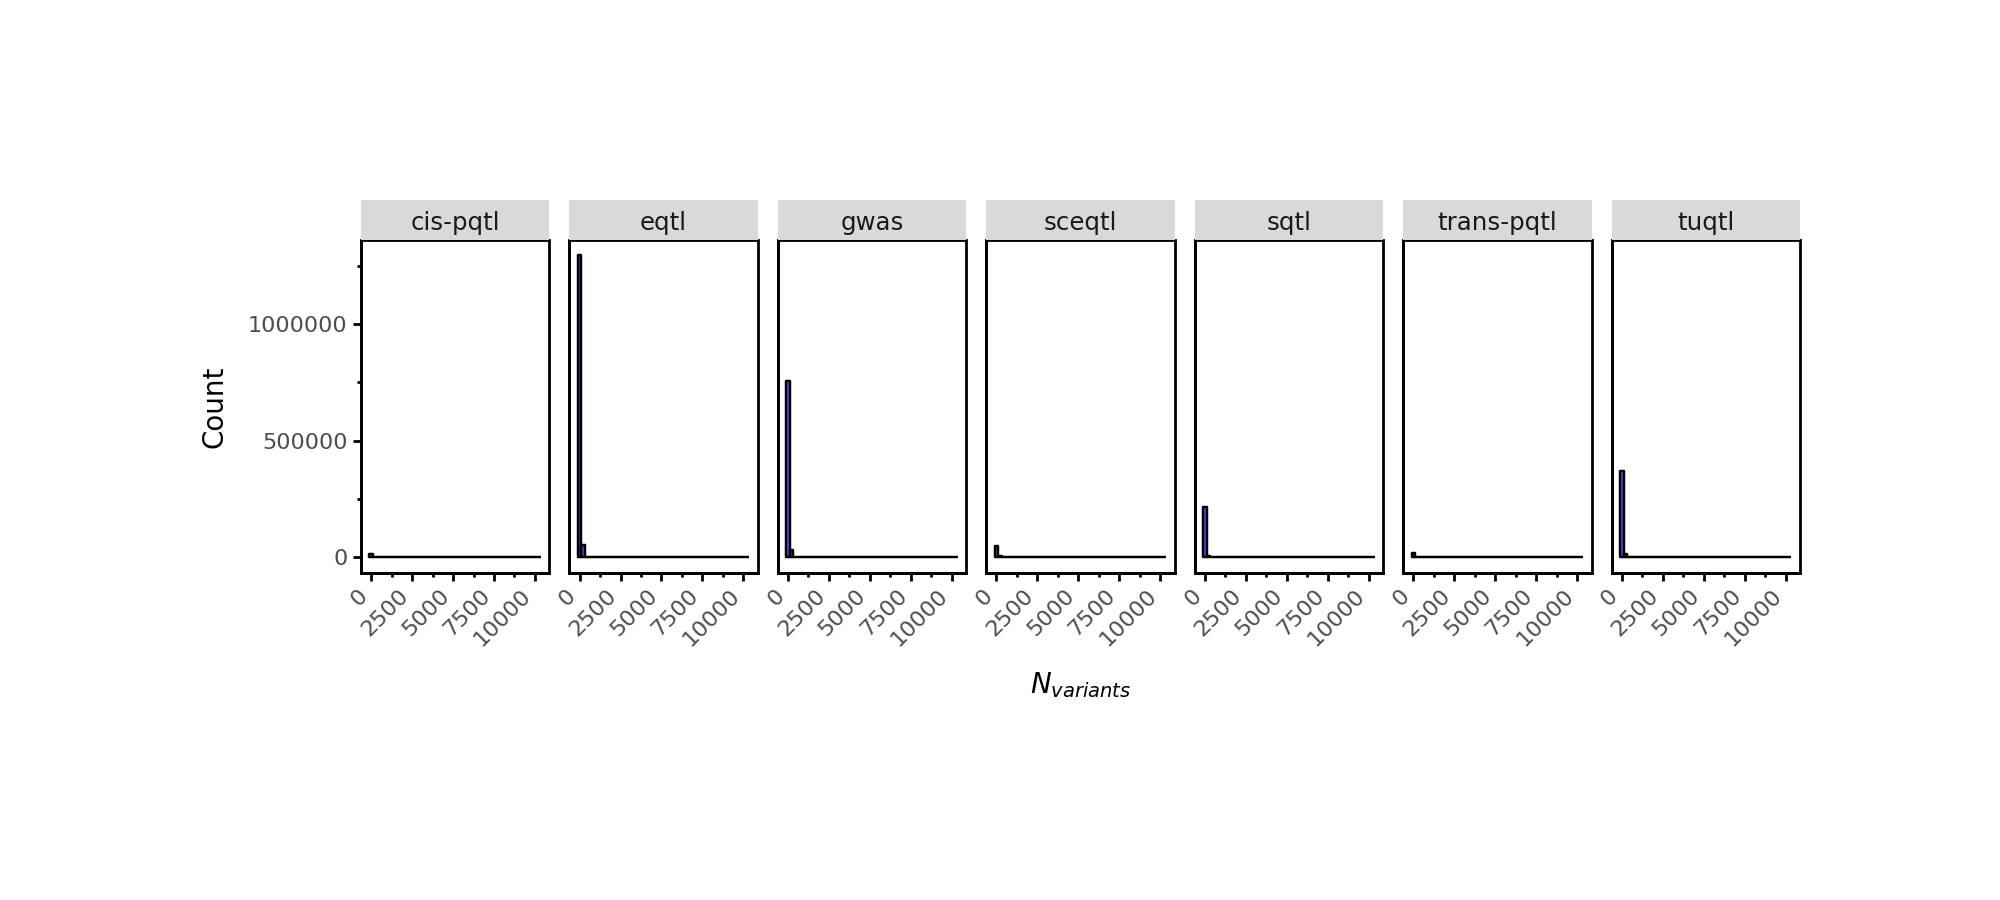

In [48]:
plot = (
    ggplot(data, aes(x="credibleSetSize", y=after_stat("count")))
    + geom_histogram(bins=50, fill="blue", color="black", alpha=0.7)
    + facet_grid(cols="studyType")
    + theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        plot_margin=0.1,
    )
    + labs(x=r"$N_{variants}$", y="Count")
)
plot


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 113746 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 14 rows containing missing values.


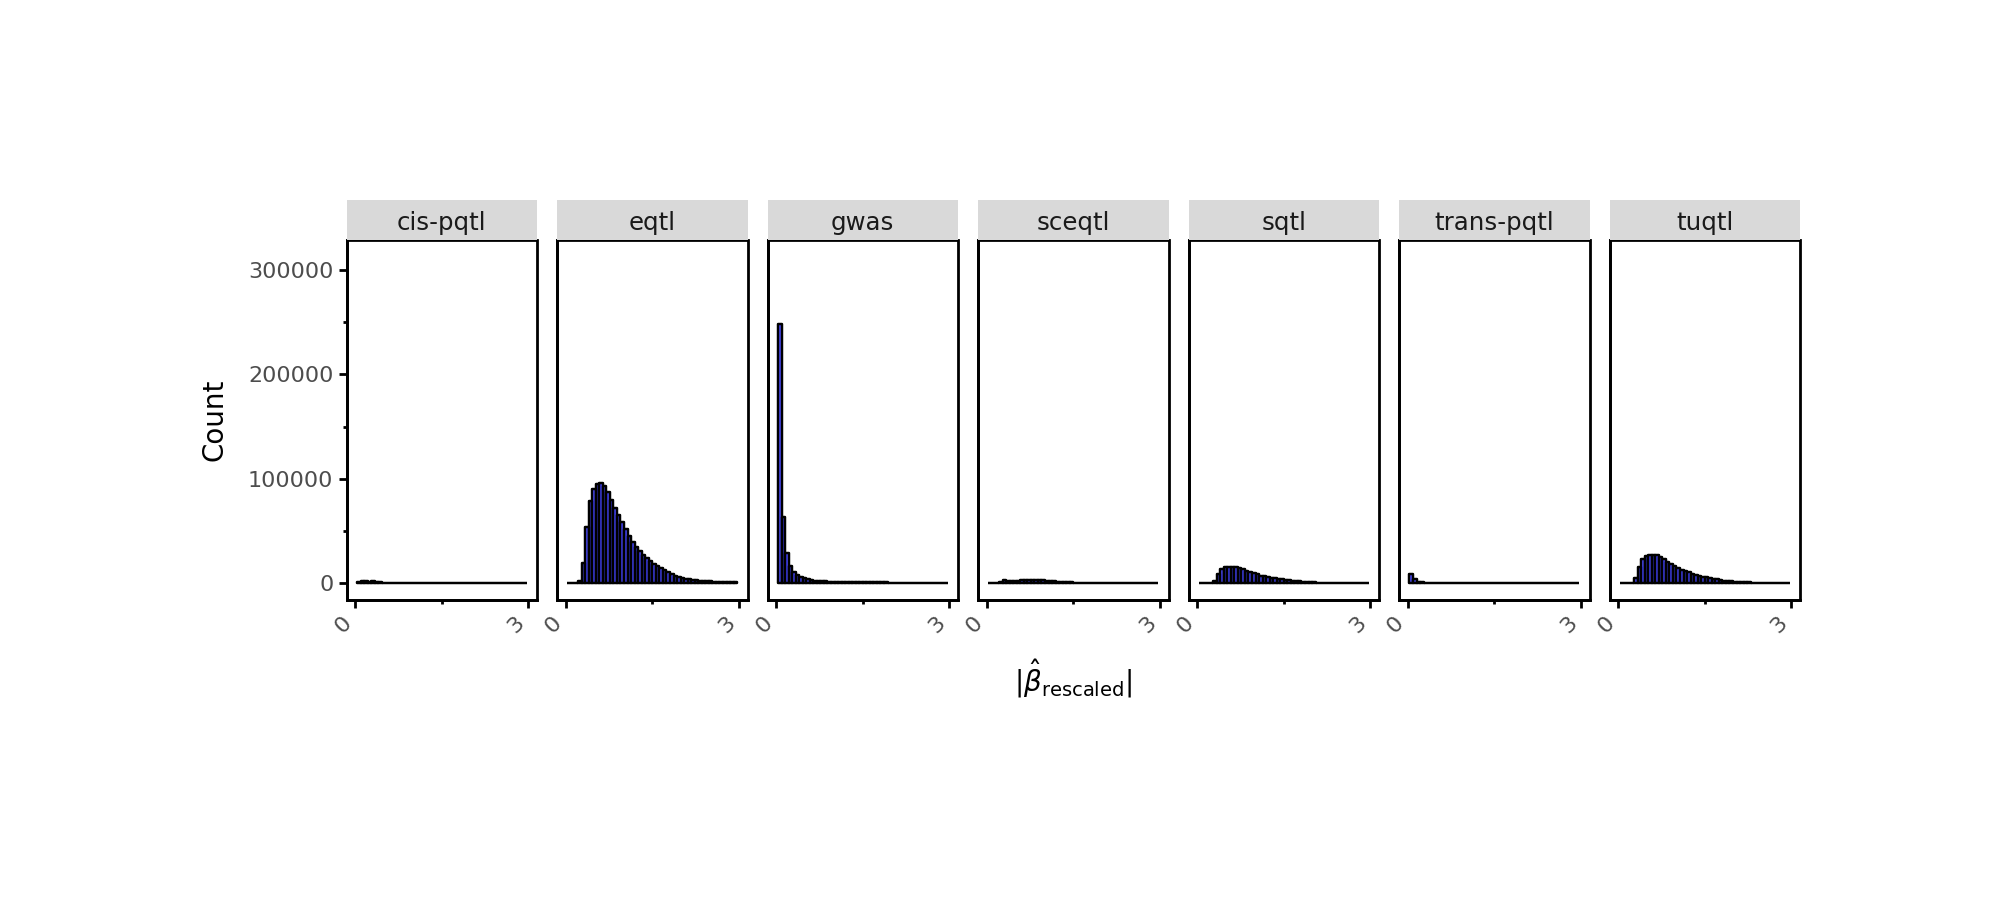

In [61]:
data["absEstimatedBeta"] = data["estimatedBeta"].abs()
plot = (
    ggplot(data, aes(x="absEstimatedBeta", y=after_stat("count")))
    + geom_histogram(bins=50, fill="blue", color="black", alpha=0.7)
    + facet_grid(cols="studyType")
    + theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        plot_margin=0.1,
    )
    + labs(x=r"$|\hat{\beta}_{\mathrm{rescaled}}|$", y="Count")
    + scale_x_continuous(limits=(0, 3), breaks=[0, 3], labels=["0", "3"])
    # + scale_y_continuous(limits=(0, 1000), breaks=[0, 500, 1000], labels=["0", "500", "1000"])
)
plot


## credible set size vs MAF

Regression according to the model:
$$ \text{credibleSetSize} \sim \text{MAF} + \text{studyType} + (1 | \text{studyType}) $$

In [ ]:
data = data.dropna(subset=["MAF", "credibleSetSize", "absEstimatedBeta"])


In [ ]:
from statsmodels.formula.api import mixedlm

model = mixedlm("credibleSetSize ~ MAF", data, groups=data["studyType"])
result = model.fit()
print(result.summary())


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: credibleSetSize
No. Observations: 2820468  Method:             REML           
No. Groups:       7        Scale:              7535.1548      
Min. group size:  15933    Log-Likelihood:     -16591737.9268 
Max. group size:  1348868  Converged:          Yes            
Mean group size:  402924.0                                    
---------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      21.540    32.810   0.657  0.511  -42.766  85.846
MAF            17.872     0.340  52.491  0.000   17.204  18.539
Group Var    7535.155                                          



In [ ]:
model = mixedlm("absEstimatedBeta ~ MAF", data, groups=data["studyType"])
result = model.fit()
print(result.summary())


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


             Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: absEstimatedBeta
No. Observations: 2820468  Method:             REML            
No. Groups:       7        Scale:              10.0393         
Min. group size:  15933    Log-Likelihood:     -7254829.1057   
Max. group size:  1348868  Converged:          Yes             
Mean group size:  402924.0                                     
----------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept       2.113     1.198     1.765  0.078  -0.234   4.460
MAF            -5.332     0.012  -429.025  0.000  -5.356  -5.307
Group Var      10.039                                           



In [ ]:
model = mixedlm("credibleSetSize ~ absEstimatedBeta", data, groups=data["studyType"])
result = model.fit()
print(result.summary())


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable: credibleSetSize
No. Observations:  2820468  Method:             REML           
No. Groups:        7        Scale:              7537.2143      
Min. group size:   15933    Log-Likelihood:     -16592126.3897 
Max. group size:   1348868  Converged:          Yes            
Mean group size:   402924.0                                    
---------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept          26.238   32.814   0.800 0.424 -38.077 90.552
absEstimatedBeta   -0.704    0.016 -44.541 0.000  -0.735 -0.673
Group Var        7537.214                                      

